In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
from matplotlib import animation, rc

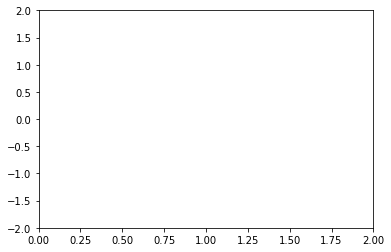

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)
# these are the artists imo

In [ ]:
def init_fn():
  line.set_data([], [])
  return line, 

In [ ]:
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

In [ ]:
rc('animation', html='jshtml')

anim = animation.FuncAnimation(fig, animate, init_func = init_fn, 
                               frames = 200, interval = 10, blit = True)

anim
# frames == ?
# interval == ?
# blit == ? -- means redraw only the parts that have changed

In [ ]:
anim.save('basic_animation.mp4', fps=50, extra_args=['-vcodec', 'libx264'])


In [ ]:
import math

def beta_pdf(x, a, b):
    return (x**(a-1) * (1-x)**(b-1) * math.gamma(a + b)
            / (math.gamma(a) * math.gamma(b)))

class UpdateDist:
  def __init__(self, ax, prob = 0.5):
    self.success = 0
    self.prob = prob
    self.line, = ax.plot([], [], 'k-') # init the artist
    self.x = np.linspace(0, 1, 100) # init the x-axis space
    self.ax = ax

    # set up plot params
    self.ax.set_xlim(0, 1) # we are modelling beta_pdf(x | a, b)
    self.ax.set_ylim(0, 10) # density
    self.ax.grid(True)

    # this vertical line represetns theoretical value, to which
    # the plotted distribution should converge
    self.ax.axvline(prob, linestyle = "--", color = "black") # the fucks prob

  def __call__(self, i):
    # equivalent to update .. animate.. etc
    if i == 0:
      self.success = 0
      self.line.set_data([], []) # the init_fn stage --> init the artist
      return self.line, # --> init fn should return artist

    # with probability of prob
    if np.random.rand(1, ) < self.prob:
      self.success += 1
    y = beta_pdf(self.x, self.success + 1, (i - self.success) + 1)
    self.line.set_data(self.x, y)
    return self.line, 

# Fixing random state for reproducibility
np.random.seed(19680801)


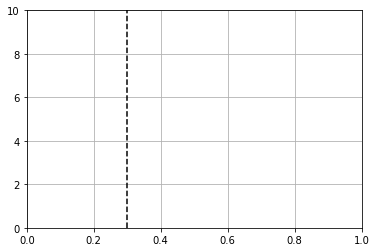

In [ ]:
fig, ax = plt.subplots()
ud = UpdateDist(ax, prob=0.3)
anim = animation.FuncAnimation(fig, ud, frames=100, interval=100, blit=True)

In [ ]:
anim

In [ ]:
!pip install arviz

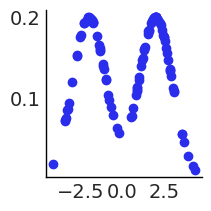

In [ ]:
# lets write mcmc :)))))
import arviz as az
import scipy.stats as st

FIGSIZE = (9, 6)
az.style.use('arviz-white')

class MixtureOfGaussians:
    """Two standard normal distributions, centered at +2 and -2."""
    def __init__(self):
        self.components = [st.norm(-2, 1), st.norm(2, 1)]
        self.weights = np.array([0.5, 0.5])

    def pdf(self, x):
        return self.weights.dot([component.pdf(x) for component in self.components])

    def rvs(self, size=1):
        idxs = np.random.randint(0, 2, size=size) # -> works coz weights is 0.5, 0.5
        result = np.empty(size)
        for idx, component in enumerate(self.components):
            spots, = np.where(idxs==idx)
            result[spots] = component.rvs(size=spots.shape[0])
        return result

dist = MixtureOfGaussians()
samples = dist.rvs(100)
pdfs = dist.pdf(samples)
plt.figure(figsize = (2, 2))
plt.scatter(samples, pdfs)
plt.show()

In [ ]:
# say we don't have access to sampling. 
def metro(pdf, *, steps, step_size, init = 0):
    point = init
    samples = []
    for _ in range(steps):
        proposed = st.norm(point, step_size).rvs() # proposal from N (prev, var)
        if np.random.rand() < pdf(proposed) / pdf(point): # acceptance = pdf(proposed) / pdf(prev)
            point = proposed
        samples.append(point)
    return np.array(samples)

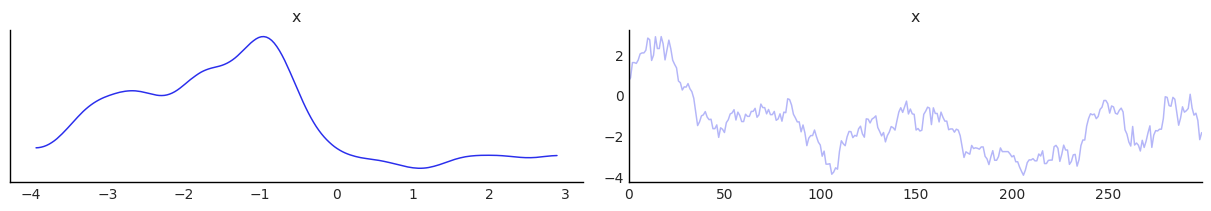

In [ ]:
seed = 0
np.random.seed(seed)
samples = metro(MixtureOfGaussians().pdf, steps=300, step_size=0.4)
az.plot_trace(samples);
# plot shows pdf on left, # how samples vary with time on right
# fairly ok mixing

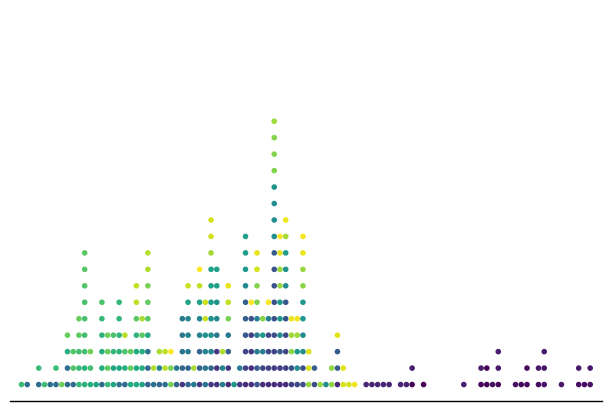

In [ ]:
hi, lo = samples.max(), samples.min()
x = np.linspace(lo, hi, 100) # pick 100 bins?
bins = np.digitize(samples, x, right = True) # --> quantizing to [0, 100] space

# I NEED PER POINT HEIGHT
per_point_height = np.zeros_like(bins)  # y values
counts = np.zeros_like(x)  # keep track of how points are already in each bin
for idx, bin_ in enumerate(bins):
    counts[bin_] += 1
    per_point_height[idx] = counts[bin_]
per_point_height = per_point_height / per_point_height.max()



fig, ax = plt.subplots(figsize = (6, 4))
ax.set_ylim(0, 1.4)
ax.set_xlim(bins.min()-2, bins.max()+2) # coz depends on sampling
ax.spines['right'].set_visible(False) #meaning? --> the border line [ANKIFY]
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.get_yaxis().set_visible(False)
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, bins.shape[0])) # picking em colors biiitccc


ax.scatter(bins, per_point_height, marker='.', facecolors=colors);
# a darker point is old!
# a lighter point is recent

In [ ]:
bins.shape[0]

300

In [ ]:
xdata, ydata = [], []
for i in range(3):
  xdata.append(bins[i])
  ydata.append(per_point_height[i])
  colors = cmap(np.linspace(0, 1, len(xdata))) # color ranges for current set of points
  offset = 1 - 1/50 + (np.arange(i+1) - i) / 50 # --> what -- the height at which each particle starts!!
  y = np.maximum(ydata, offset)
  print(np.array([xdata, y]).T)

[[68.    0.98]]
[[68.    0.96]
 [70.    0.98]]
[[68.    0.94]
 [70.    0.96]
 [81.    0.98]]


In [ ]:
np.arange(bins.shape[0]).shape

(300,)

In [ ]:
(49/50 - 0.176) * 50

40.2

In [ ]:
# base stuff
fig, ax = plt.subplots();
xdata, ydata = [], []
ln = ax.scatter([], [], marker = ".", animated = True) # artist
cmap = plt.get_cmap('viridis')

def init_fn():
  ax.set_xlim(bins.min() - 1, bins.max() + 1)
  ax.set_ylim(0, 1.4)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)

  ax.set_xticks([])
  ax.get_yaxis().set_visible(False)
  return ln, # return artist

def update(i):

  if i >= bins.shape[0]:
    offset = (np.arange(bins.shape[0]) - i + 49) / 50
  else:
    xdata.append(bins[i])
    ydata.append(per_point_height[i])
    offset = (np.arange(i + 1) - i + 49) / 50 # --> what
  
  colors = cmap(np.linspace(0, 1, len(xdata))) # color ranges for current set of points
  y = np.maximum(ydata, offset)
  ln.set_offsets(np.array([xdata, y]).T)
  ln.set_facecolors(colors)
  return ln, 

anim = animation.FuncAnimation(fig, update, frames = bins.shape[0] + 49, 
                               init_func = init_fn, blit = True, interval = 10)

# anim = FuncAnimation(fig, update, frames=np.arange(bins.shape[0]),
#                      init_func=init, blit=True, interval=20)
anim

Output hidden; open in https://colab.research.google.com to view.

In [7]:
class AnimatedScatterTransition(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, 
                 point_lst, 
                 colors=None, 
                 transition_steps=100,
                 pause_steps=50,
                 title=None):
        self.numpoints = len(point_lst[0]) # 2000
        self.point_lst = point_lst
        self.colors = colors
        self.transition_steps = transition_steps
        self.pause_steps = pause_steps
        n_frames = (transition_steps + pause_steps) * len(point_lst) - transition_steps + 20

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots(figsize = (9, 6))
        
        
        if title is not None:
            self.ax.set_title(title)
        self.setup_plot()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=30, frames=n_frames,
                                          init_func=self.init_fn, blit=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        locs = self.get_scatter_coords(0)
        x, y = locs[:,0], locs[:,1]
        self.scat = self.ax.scatter([], [], s=1.5)
        all_pts = np.concatenate(self.point_lst, axis=0)
        maxes = np.max(all_pts, axis=0)
        mins = np.min(all_pts, axis=0)
        self.ax.axis([mins[0], maxes[0], mins[1], maxes[1]])
        self.some_text = self.ax.text(0.02, 0.95, '', transform=self.ax.transAxes)
        self.another_text = self.ax.text(0.02, 0.90, '', transform=self.ax.transAxes)
    
    def init_fn(self):
        # Set x and y data...
        offsets = np.empty([self.numpoints, 2])
        offsets[:] = np.nan
        self.scat.set_offsets(offsets)
        self.some_text.set_text('')
        self.another_text.set_text('')

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # it expects a sequence of artists, thus the trailing comma.
        return self.scat, self.some_text, self.another_text
    
    def get_scatter_coords(self, i):
        stage_len = self.pause_steps + self.transition_steps
        idx = i // stage_len
        offset = i % stage_len
        if idx >= len(self.point_lst) - 1:
            return self.point_lst[-1] # the last frames.. ie, z
        elif offset < self.pause_steps:
            return self.point_lst[idx] # pause : show the current z_i
        else:
            offset -= self.pause_steps # the transition step for this frame..
            # (1-alpha) * curr + (alpha) * next
            # where.. alpha = offset / transition_steps
            return self.point_lst[idx] * (self.transition_steps - offset) / self.transition_steps + self.point_lst[idx+1] * offset / self.transition_steps

    def update(self, i):
        """Update the scatter plot."""
        data = self.get_scatter_coords(i)

        # set x and y 
        self.scat.set_offsets(data[:, :2]) # i mean sure.. 

        # set colors
        self.scat.set_array(self.colors)

        self.some_text.set_text('frame number = %d' % i)
        self.another_text.set_text('time = %.3f s' % (i * 0.03))

        # return the updated artist for FuncAnimation to draw
        # it expects a sequence of artists, thus the trailing comma
        return self.scat, self.some_text, self.another_text

In [10]:
representations = np.load("reps_nvp.npy")


a = AnimatedScatterTransition(representations[0::2], transition_steps=40, pause_steps=10, title='RealNVP Intermediate Layer')
plt.close()
rc('animation', html='jshtml')

In [11]:
a.ani

Output hidden; open in https://colab.research.google.com to view.

In [12]:
a.ani.save('realnvp_slant.mp4', fps=50, extra_args=['-vcodec', 'libx264'])

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng


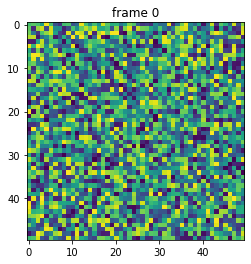

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)
data = np.random.random((50, 50, 50))

fig, ax = plt.subplots()

for i in range(len(data)):
    ax.cla()
    ax.imshow(data[i])
    ax.set_title("frame {}".format(i))
    # Note that using time.sleep does *not* work here!
    plt.pause(0.1)

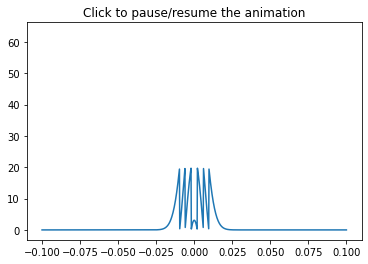

In [4]:
from matplotlib import animation, rc

rc('animation', html='jshtml')

class PauseAnimation:
    def __init__(self):
        fig, ax = plt.subplots()
        ax.set_title('Click to pause/resume the animation')
        x = np.linspace(-0.1, 0.1, 1000)

        # Start with a normal distribution
        self.n0 = (1.0 / ((4 * np.pi * 2e-4 * 0.1) ** 0.5)
                   * np.exp(-x ** 2 / (4 * 2e-4 * 0.1)))
        self.p, = ax.plot(x, self.n0)

        self.animation = animation.FuncAnimation(
            fig, self.update, frames=200, interval=50, blit=True)
        self.paused = False

        fig.canvas.mpl_connect('button_press_event', self.toggle_pause)

    def toggle_pause(self, *args, **kwargs):
        if self.paused:
            self.animation.resume()
        else:
            self.animation.pause()
        self.paused = not self.paused

    def update(self, i):
        self.n0 += i / 100 % 5
        self.p.set_ydata(self.n0 % 20)
        return (self.p,)


pa = PauseAnimation()

In [6]:
pa.animation

Output hidden; open in https://colab.research.google.com to view.